<a href="https://colab.research.google.com/github/sgh4000/NLPSafeAI/blob/sh%2Finitial/Lab1and2_newdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Using this dataset - https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned?resource=download

# Following the Kaggle download instructions
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Set the path to the file you'd like to load
file_path = "depression_dataset_reddit_cleaned.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "infamouscoder/depression-reddit-cleaned",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

clean_text = df['clean_text']
display(clean_text[:5])

/tmp/ipython-input-1581979753.py:12: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'depression-reddit-cleaned' dataset.


0    we understand that most people who reply immediately to an op with an invitation to talk privately mean only to help but this type of response usually lead to either disappointment or disaster it usually work out quite differently here than when you say pm me anytime in a casual social context we have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content even more so because we know that so many of you are struggling yourselves we re hard at work behind the scene on more information and resource to make it easier to give and get quality help here this is just a small start our new wiki page explains in detail why it s much better to respond in public comment at least until you ve gotten to know someone it will be maintained at r depression wiki private contact and the full text of the current version is below summary anyone who while acting a a helper invite or accepts private contact i e pm chat or any kind of offsite communication early in the conversion is showing either bad intention or bad judgement either way it s unwise to trust them pm me anytime seems like a kind and generous offer and it might be perfectly well meaning but unless and until a solid rapport ha been established it s just not a wise idea here are some point to consider before you offer or accept an invitation to communicate privately by posting supportive reply publicly you ll help more people than just the op if your response are of good quality you ll educate and inspire other helper the 9 90 rule http en wikipedia org wiki rule internet culture applies here a much a it doe anywhere else on the internet people who are struggling with serious mental health issue often justifiably have a low tolerance for disappointment and a high level of ever changing emotional need unless the helper is able to make a 00 commitment to be there for them in every way for a long a necessary offering a personal inbox a a resource is likely to do more harm than good this is why mental health crisis line responder usually don t give their name and caller aren t allowed to request specific responder it s much healthier and safer for the caller to develop a relationship with the agency a a whole analogously it s much safer and healthier for our ops to develop a relationship with the community a a whole even trained responder are generally not allowed to work high intensity situation alone it s partly about availability but it s mostly about wider perspective and preventing compassion fatigue if a helper get in over their head with someone whose mental health issue including suicidality which is often comorbid with depression escalate in a pm conversation it s much harder for others including the r depression and r suicidewatch moderator to help contrary to common assumption moderator can t see or police pm in our observation over many year the people who say pm me the most are consistently the one with the least understanding of mental health issue and mental health support we all have gap in our knowledge and in our ability to communicate effectively community input mitigates these limitation there s no reason why someone who s truly here to help would want to hide their response from community scrutiny if helper are concerned about their own privacy keep in mind that self disclosure when used supportively is more about the feeling than the detail and that we have no problem here with the use of alt throwaway account and have no restriction on account age or karma we all know the internet is used by some people to exploit or abuse others these people do want to hide their deceptive and manipulative response from everyone except their victim there are many of them who specifically target those who are vulnerable because of mental health issue if a helper invite an op to talk privately and give them a good supportive experience they ve primed that person to be more vulnerable to abuse

In [2]:
# Investigate the data

# Count how many records of each type, depression means is_depression = 1 and no depression means is_depression = 0

depression_count = df['is_depression'].value_counts()
print(depression_count)

is_depression
0    3900
1    3831
Name: count, dtype: int64


In [3]:
#####################################
### Import the relevant libraries ###
#####################################

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import requests
from sentence_transformers import SentenceTransformer
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA

In [4]:
# Split into train/test

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["is_depression"]
)

# Extract training features and labels if needed. Keeping raw for future analysis
X_train_raw = df_train["clean_text"].tolist()
y_train = df_train["is_depression"].values
X_test_raw = df_test["clean_text"].tolist()
y_test = df_test["is_depression"].values

In [5]:
########################################################
### I want to do some analysis on the PCA embeddings ###
########################################################

# Also, I want to investigate how different number of components has an effect

# The pca.explained_variance_ratio returns a vector of the variance explained by each dimension
# So [0.11,0.095,0.085] means that the first dimension explains 11% of variance and so on
# explained_variance_ratio_.cumsum gives the cumulated totals, so taking the final value gives the
# total variance explained by all dimensions

import matplotlib.pyplot as plt

encoding_model = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(encoding_model)
n_components = 30

X_train = encoder.encode(X_train_raw, show_progress_bar=False)
X_test = encoder.encode(X_test_raw, show_progress_bar=False)

data = np.vstack([X_train])
# PCA data
data_pca = PCA(n_components=n_components).fit(data)

print("---- n = 30 ----")

cum_sum_30 = data_pca.explained_variance_ratio_.cumsum()[-1]

print(f"Cum sum {n_components} is {cum_sum_30:.3f}")

n_components = 50

X_train = encoder.encode(X_train_raw, show_progress_bar=False)
X_test = encoder.encode(X_test_raw, show_progress_bar=False)

data = np.vstack([X_train])
# PCA data
data_pca = PCA(n_components=n_components).fit(data)

print("---- n = 50 ----")

cum_sum_50 = data_pca.explained_variance_ratio_.cumsum()[-1]

print(f"Cum sum {n_components} is {cum_sum_50:.3f}")


# n_components = 70

# X_train = encoder.encode(X_train_raw, show_progress_bar=False)
# X_test = encoder.encode(X_test_raw, show_progress_bar=False)

# data = np.vstack([X_train])
# PCA data
# data_pca = PCA(n_components=n_components).fit(data)

# print("---- n = 70 ----")

# cum_sum_70 = data_pca.explained_variance_ratio_.cumsum()[-1]

# print(f"Cum sum {n_components} is {cum_sum_70:.3f}")

# n_components = 100

# X_train = encoder.encode(X_train_raw, show_progress_bar=False)
# X_test = encoder.encode(X_test_raw, show_progress_bar=False)

# data = np.vstack([X_train])
# PCA data
# data_pca = PCA(n_components=n_components).fit(data)

# print("---- n = 100 ----")

# cum_sum_100 = data_pca.explained_variance_ratio_.cumsum()[-1]

# print(f"Cum sum {n_components} is {cum_sum_100:.3f}")

# n_components = 200

# X_train = encoder.encode(X_train_raw, show_progress_bar=False)
# X_test = encoder.encode(X_test_raw, show_progress_bar=False)

# data = np.vstack([X_train])
# PCA data
# data_pca = PCA(n_components=n_components).fit(data)

# print("---- n = 200 ----")

# cum_sum_200 = data_pca.explained_variance_ratio_.cumsum()[-1]

# print(f"Cum sum {n_components} is {cum_sum_200:.3f}")

# plt.plot([30, 50, 70, 100, 200], [cum_sum_30, cum_sum_50, cum_sum_70, cum_sum_100, cum_sum_200], marker='o')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance Ratio')
# plt.title('Cumulative Explained Variance Ratio by Principal Components')
# plt.ylim(bottom=0)
# plt.show()





/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


---- n = 30 ----
Cum sum 30 is 0.435
---- n = 50 ----
Cum sum 50 is 0.540


In [6]:
##################################################
### Do the text embeddings needed for training ###
##################################################

encoding_model = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(encoding_model)
n_components = 30
batch_size = 64

X_train = encoder.encode(X_train_raw, show_progress_bar=False)
X_test = encoder.encode(X_test_raw, show_progress_bar=False)

data = np.vstack([X_train])
# PCA data
data_pca = PCA(n_components=n_components).fit(data)

X_train = data_pca.transform(X_train)
X_test = data_pca.transform(X_test)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [7]:
###############################################################################################################
### Define a simple model - credit for this spec https://github.com/Tgl70/DAIR-course-NLP/blob/main/main.py ###
###############################################################################################################

print(y_train.shape, y_train[:10])
print(y_test.shape, y_test[:10])

def get_model(input_size):
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_size,), name='input_features'),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, name='dense_1'),
            tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=initializer, name='output_layer')
        ])
    print(model.summary())
    return model

(6184,) [1 0 1 0 0 0 1 0 1 0]
(1547,) [1 1 0 0 1 1 1 0 0 0]


In [8]:
##########################
### Set some variables ###
##########################

input_size = X_train.shape[1]
batch_size = 64
epochs = 6
n_classes = 2
epsilon = 0.3
alpha = 0.1
num_iter = 10

In [9]:
########################################################
### Train the base model (simple and no adversarial) ###
########################################################

model_base = get_model(input_size)

model_base.summary()

model_base.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    )

model_base.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,226 (16.51 KB)

 Trainable params: 4,226 (16.51 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,226 (16.51 KB)

 Trainable params: 4,226 (16.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7294 - loss: 0.6267 - val_accuracy: 0.9483 - val_loss: 0.3399
Epoch 2/6
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9541 - loss: 0.2806 - val_accuracy: 0.9502 - val_loss: 0.1712
Epoch 3/6
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9594 - loss: 0.1573 - val_accuracy: 0.9509 - val_loss: 0.1385
Epoch 4/6
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9589 - loss: 0.1326 - val_accuracy: 0.9522 - val_loss: 0.1285
Epoch 5/6
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9596 - loss: 0.1275 - val_accuracy: 0.9548 - val_loss: 0.1242
Epoch 6/6
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9599 - loss: 0.1267 - val_accuracy: 0.9535 - val_loss: 0.1215


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision (macro): 0.9540
Recall (macro): 0.9533
F1-score (macro): 0.9534


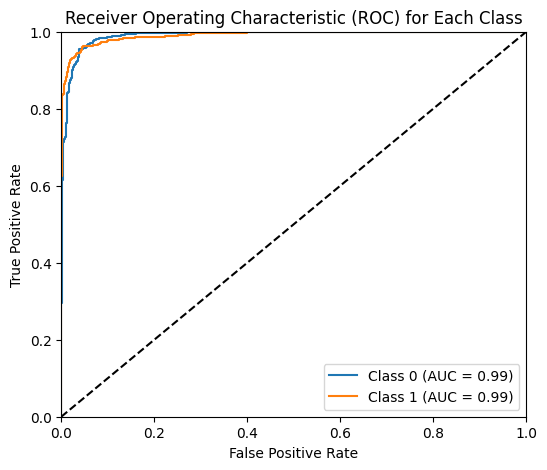

In [10]:
###############################################################
### Define the precision, recall, F1 and ROC curve function ###
###############################################################

# Taken from lab https://github.com/KatyaKom/DAIR/blob/main/Lab2/CV.ipynb

def print_metrics(model, x, y, c):
    # Get predicted probabilities for all classes
    y_pred_prob = model.predict(x)

    # Get predicted class labels (highest probability class)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # Calculate precision, recall, and F1-score (using macro average)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')

    # Display the macro/micro/weighted average metrics
    print(f'Precision (macro): {precision:.4f}')
    print(f'Recall (macro): {recall:.4f}')
    print(f'F1-score (macro): {f1:.4f}')

    y_test_bin = to_categorical(y, num_classes=c)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(c):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

    # Plot the ROC curve for each class
    plt.figure(figsize=(6, 5))
    for i in range(c):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc='lower right')
    plt.show()

print_metrics(model_base, X_test, y_test, 2)

In [11]:
#######################################
### Calculate the loss and accuracy ###
#######################################

loss, acc = model_base.evaluate(X_test, y_test, verbose=0)

print(f"Base model loss: {loss:.3f}")
print(f"Base model accuracy: {acc:.3f}")


Base model loss: 0.121
Base model accuracy: 0.953


In [12]:
##################
### LIME Setup ###
##################

%pip install Lime
from lime.lime_text import LimeTextExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ec5f5ca3d51e27bb05e1dfe1b0fb876f5dc6bd6fa9a6a08d65c6d9eba72622dd
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built Lime


query: tolu pepper my dear ovulation pm and period make my life complicated the depression symptom emotional weariness edginess tiredness actual pain it s just a lot you are not alone si we are all frustrated with you sending hug
<function make_predict_fn.<locals>.predict_fn at 0x7e2381e31120>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model probabilities: [[0.27260485 0.7273951 ]]
Pred class: 1

LIME Explanation for: 'tolu pepper my dear ovulation pm and period make my life complicated the depression symptom emotional weariness edginess tiredness actual pain it s just a lot you are not alone si we are all frustrated with you sending hug'

Class 0 (non-depression) explanation:
  depression: -0.1445
  emotional: -0.0486
  pepper: 0.0245
  symptom: -0.0238
  frustrated: -0.0218
  life: -0.0208
  pm: -0.0175
  dear: 0.0110
  sending: 0.0108
  tolu: 0.0106

Class 1 (depression) explanation:
  depression: 0.1445
  emotional: 0.0486
  pepper: -0.0245
  sy

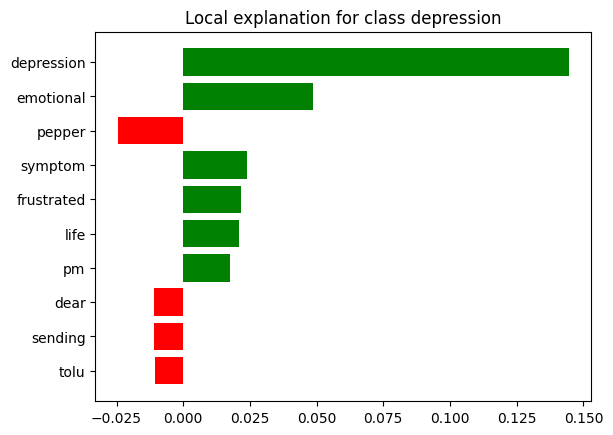




query: to be fair i don t have access to much of my family s history past my parent so i don t know if there s a possibility that someone in my family tree had anxiety but when i wa younger i remember taking online test about anxiety because i couldn t see a therapist then worrying about the result did i somehow create my anxiety by self diagnosis then spin it into the real thing
<function make_predict_fn.<locals>.predict_fn at 0x7e237ebca5c0>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model probabilities: [[0.26955047 0.7304495 ]]
Pred class: 1

LIME Explanation for: 'to be fair i don t have access to much of my family s history past my parent so i don t know if there s a possibility that someone in my family tree had anxiety but when i wa younger i remember taking online test about anxiety because i couldn t see a therapist then worrying about the result did i somehow create my anxiety by self diagnosis then spin it into the real thing'

Class 0

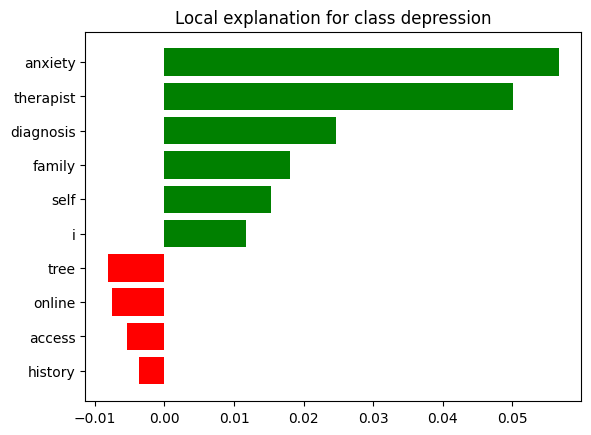




{'tolu pepper my dear ovulation pm and period make my life complicated the depression symptom emotional weariness edginess tiredness actual pain it s just a lot you are not alone si we are all frustrated with you sending hug': 'depression', 'to be fair i don t have access to much of my family s history past my parent so i don t know if there s a possibility that someone in my family tree had anxiety but when i wa younger i remember taking online test about anxiety because i couldn t see a therapist then worrying about the result did i somehow create my anxiety by self diagnosis then spin it into the real thing': 'anxiety'}


In [14]:
####################
### LIME Explain ###
####################

# Local Interpretable Model-Agnostic Explanations
# LIME is representing local explanation, need to be mindful that a local explanation isn't a global explanation

queries = X_test_raw[:2]

encoder = SentenceTransformer("all-MiniLM-L6-v2")

class_names = ["non-depression", "depression"]


def make_predict_fn(model, encoder, pca):
    def predict_fn(texts):
        X_encoded = encoder.encode(texts, show_progress_bar=False)
        X_pca = pca.transform(X_encoded)
        preds = model.predict(X_pca)
        return tf.nn.softmax(preds, axis=1).numpy()
    return predict_fn

def explain_text(query, model, encoder, pca, class_names, print_out=True):

    print(f"query: {query}")

    predict_fn = make_predict_fn(model, encoder, pca)
    explainer = LimeTextExplainer(class_names=class_names, random_state=42)

    print(predict_fn)

    predicted_probs = predict_fn([query])
    pred_class = int(np.argmax(predicted_probs))

    exp = explainer.explain_instance(
        query,
        predict_fn,
        num_features=10,
        labels=[0,1]
    )

    print("Model probabilities:", predicted_probs)

    print(f"Pred class: {pred_class}")
    if (print_out == True):
      print(f"\nLIME Explanation for: '{query}'")
      available_labels = exp.available_labels()
      for label in available_labels:
          print(f"\nClass {label} ({class_names[label]}) explanation:")
          for word, weight in exp.as_list(label=label):
              print(f"  {word}: {weight:.4f}")

      print(exp.as_list(label=pred_class))

      exp.as_pyplot_figure(label=pred_class)
      plt.show()

      print("\n\n")


    return exp

query_and_important_word = {}

for q in queries:
  exp = explain_text(q, model_base, encoder, data_pca, class_names)
  query_and_important_word[q] = str(exp.as_list()[0][0])


print(query_and_important_word)

In [15]:
######################################
### SHAP Analysis helper functions ###
######################################

import shap
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle as pk
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import pandas as pd
from collections import Counter

def feature_importance_graph(X_train, X_test, model):
  # Take a small subset of the training data to explain using SHAP
  background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
  to_explain = X_test[:100]

  explainer = shap.KernelExplainer(model.predict, background)
  shap_values = explainer.shap_values(to_explain)

  # Want to measure how features push towards class 1
  shap_diff = shap_values[..., 1] - shap_values[..., 0]

  shap.summary_plot(
    shap_diff, to_explain,
    feature_names=[f"f{i}" for i in range(X_train.shape[1])]
  )

  return shap_diff

def get_associated_queries_for_top_features(no_top_PCA_features, no_top_embedding_dimensions, no_top_text_queries, pca, encoder, queries_raw, shap_diff):
  # The idea here is that we can use SHAP to find the most important PCA features. From here, find the embeddings that drive them. Then look at real queries (from training data) that score highly for these embeddings.

  encoder = SentenceTransformer(encoder)
  embeddings = encoder.encode(queries_raw, show_progress_bar=False)

  X_pca = pca.transform(embeddings)

  # Get the mean absolute SHAP values per PCA feature
  mean_abs_shap = np.abs(shap_diff).mean(axis=0)

  # Find the top PCA features
  sorted_indices = np.argsort(mean_abs_shap)
  sorted_indices_desc = np.flip(sorted_indices)
  top_features = sorted_indices_desc[:no_top_PCA_features]

  print(f"\nTop {no_top_PCA_features} PCA features ranked by SHAP importance:\n")

  # Loop over the identified top PCA features
  for rank, feature in enumerate(top_features, start=1):
    print(f"{rank}. Feature {feature}")
    print(f"  Mean absolute SHAP value: {mean_abs_shap[feature]}")

    # Find which embedding matters for the feature
    component = pca.components_[feature]
    abs_component = np.abs(component)
    sorted_indices = np.argsort(abs_component)
    sorted_indices_desc = np.flip(sorted_indices)
    top_dimensions = sorted_indices_desc[:no_top_embedding_dimensions]

    for dimension in top_dimensions:
      weight = component[dimension]
      print(f"\n  Embedding dimension {dimension} contributes to PCA feature f{feature} "f"({weight:+.4f})")

      # Identify queries where this embedding dimension is strong
      # Take all sentences, and get this embedding dimension value
      dimension_values = embeddings[:, dimension]
      # Depends on sign, if positive then largest embedding value is making PCA feature important, if negative than smallest value
      order = np.argsort(dimension_values)
      if weight > 0:
        # Then need to flip for descending
        order = order[::-1]
      # Get top queries
      top_query = order[:no_top_text_queries]
      listWords = []
      for i in top_query:
        query = queries_raw[i]
        print(f"    Query: {query} | dimension {dimension} value = {dimension_values[i]:.4f}")
        listWords.extend(query.split())

      counts = Counter(listWords)
      print(f"Common words among top queries: {counts.most_common(5)}")
    print()

  return mean_abs_shap, top_features





4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

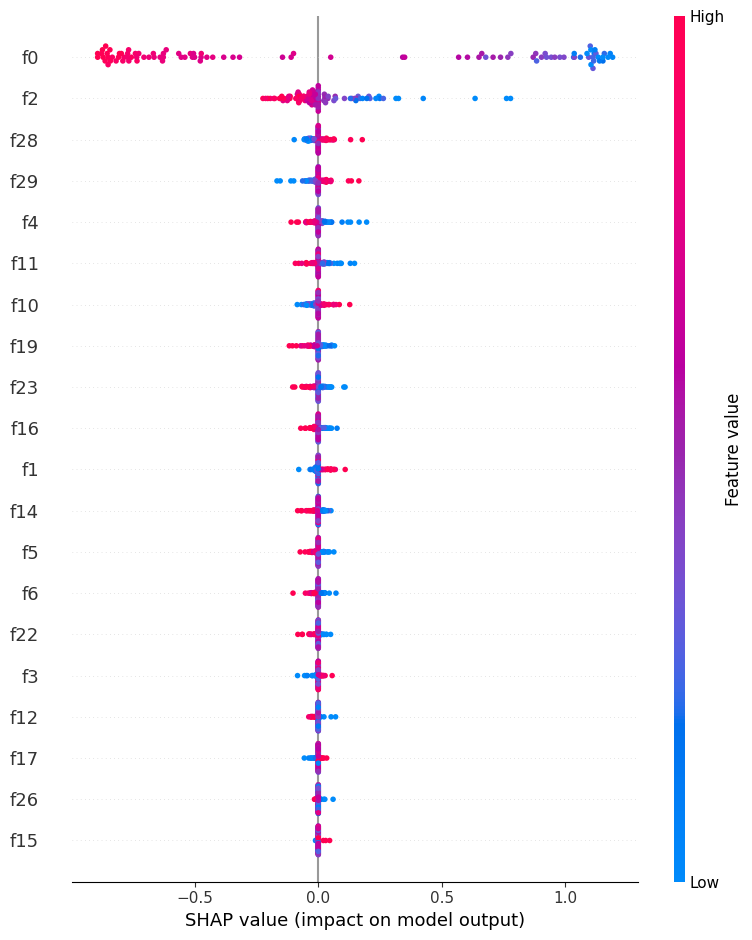


Top 3 PCA features ranked by SHAP importance:

1. Feature 0
  Mean absolute SHAP value: 0.7790866110144951

  Embedding dimension 176 contributes to PCA feature f0 (+0.1716)
    Query: james yeah gah poor illazilla and shame about the mutt but best of luck this time around | dimension 176 value = 0.1966
    Query: contactabe i m so jealous i missed all of opening day this year | dimension 176 value = 0.1616
    Query: missed the gig | dimension 176 value = 0.1615
    Query: i heard he stopped singing it s a shame http blip fm xath | dimension 176 value = 0.1605
    Query: babyvtec geez it s so late for you good luck at work tomorrow i am soooo knackered too love you | dimension 176 value = 0.1508
    Query: missed today s ellen | dimension 176 value = 0.1480
    Query: redvinylgirl my mom ha it i wish you the best of luck | dimension 176 value = 0.1451
    Query: garretjiroux do u write back on twitter i miss ya garee x | dimension 176 value = 0.1420
    Query: this break my heart nav

In [16]:
################################
### Now, doing SHAP analysis ###
################################

# A really good article on SHAP and SHAPley values and how they are calculated - https://medium.com/data-science/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30
# SHAP is quantifying the impcat that each feature has on the model's prediction

# However, unlike a model which is using specific features in input data, such as age, salary etc, we are using a text query
# So, I think it makes sense to
# 1. Identify important PCA features using SHAP
# 2. Trace them back to embedding dimensions
# 3. Then to actual text queries, to give some semantically understandable meaning

import shap
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle as pk
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import pandas as pd
from collections import Counter

# Set some values for analysis
no_top_PCA_features = 3
no_top_embedding_dimensions = 3
no_top_text_queries = 10

queries_raw = X_test_raw
encoder_name = "all-MiniLM-L6-v2"

shap_diff = feature_importance_graph(X_train, X_test, model_base)

# Look at graoh produced to understand the features which have the biggest SHAP value and thus effect on model
# Then want to investigate these features in a semantically meaningful way

mean_abs_shap, top_features = get_associated_queries_for_top_features(no_top_PCA_features, no_top_embedding_dimensions, no_top_text_queries, data_pca, encoder_name, queries_raw, shap_diff)

# An idea that has occured to me is to use LLMs to try to come up with a semantic value for each top PCA feature, given I have got queries in plain text
# Possibly something to explore?